<a href="https://colab.research.google.com/github/haosulab/ManiSkill2/blob/0.4.0/examples/tutorials/2_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code

To begin, prepare the colab environment by clicking the play button below. This will install all dependencies for the future code. This can take up to 1.5 minutes

In [ ]:
!apt-get install -y --no-install-recommends libvulkan-dev
!pip install "setuptools>=62.3.0" gym==0.21.0
!pip install -v git+https://github.com/haosulab/ManiSkill2.git@0.4.0
!pip uninstall -y pathlib  # avoid overriding the builtin one
!pip install stable-baselines3
!pip install --upgrade --no-cache-dir gdown

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import site
    site.main() # run this so local pip installs are recognized

# Robotic Learning Tutorial Part 1: Reinforcement Learning

This notebook will go over a Reinforcement Learning (RL) baseline solving the [ManiSkill](https://github.com/haosulab/ManiSkill2) environments. We will be using the [Stable Baselines 3 (SB3)](https://github.com/DLR-RM/stable-baselines3) package and the LiftCube enviornment as part of this tutorial with state and RGBD observations. Specifically,  we will use [PPO](https://openai.com/blog/openai-baselines-ppo/) algorithm to train agents.

A single-file code version of both the state based and visual based RL tutorial can be found here: https://github.com/haosulab/ManiSkill2/tree/main/examples/tutorials/reinforcement-learning

Section 1 covers State Based RL and Section 2 covers Visual RL. They are both self-contained so you can skip either section and run the other without any errors. Importantly, Section 2 covers the ManiSkill VecEnv, which brings a massive speedup to visual RL relative to other libraries.

First, we will import some packages shared by both sections and define some useful wrappers

In [3]:
# Import required packages
import gym
import gym.spaces as spaces
from tqdm.notebook import tqdm
import numpy as np
import mani_skill2.envs
import matplotlib.pyplot as plt
import torch.nn as nn
import torch as th

## 0 Useful Wrappers

For state and visual observations, there are some useful wrappers we recommend using to improve RL training and monitoring. Namely, we recommend treating tasks as continuous tasks with infinite horizon. This means `done` is always `False` until a time limit is hit.

Libraries like SB3 handle this by checking for a `info[TimeLimit.truncated]` value. The `ContinuousTaskWrapper` does this and also lets you specify your own time limit with `max_episode_steps`.

To record success rates during evaluation we also provide a `SuccessInfoWrapper` here which allows SB3 to record success rates while training.

In [4]:
# the following wrappers are importable from mani_skill2.utils.wrappers.sb3
# Defines a continuous, infinite horizon, task where done is always False
# unless a timelimit is reached.
class ContinuousTaskWrapper(gym.Wrapper):
    def __init__(self, env, max_episode_steps: int) -> None:
        super().__init__(env)
        self._elapsed_steps = 0
        self._max_episode_steps = max_episode_steps

    def reset(self):
        self._elapsed_steps = 0
        return super().reset()

    def step(self, action):
        ob, rew, done, info = super().step(action)
        self._elapsed_steps += 1
        if self._elapsed_steps >= self._max_episode_steps:
            done = True
            info["TimeLimit.truncated"] = True
        else:
            done = False
            info["TimeLimit.truncated"] = False
        return ob, rew, done, info

# A simple wrapper that adds a is_success key which SB3 tracks
class SuccessInfoWrapper(gym.Wrapper):
    def step(self, action):
        ob, rew, done, info = super().step(action)
        info["is_success"] = info["success"]
        return ob, rew, done, info

## 1 State Based RL

In state based RL, the observations are all flat/dense vectors and easy to learn from for machine learning algorithms. 

State based solving is generally much faster as generating visual observations is slow, especially without a GPU. Moreover, distillation of information from images is difficult, and state may provide privileged information about the environment that makes solving easier. However state based policies are more limited in their generalizability across tasks and objects without additional techniques.

### 1.1 Setting up Training and Evaluation Environments

We first need to setup training and evaluation environments for SB3 to use in addition to adding the custom wrappers we defined in section 0.

Note that ManiSkill2 uses GPU-optimized vectorized environments to massively speed up the simulation of environments with rendering (e.g., in visual RL). If rendering is not needed (e.g., in this case, state based RL), you do not need to use the GPU-optimized vectorized environment of ManiSkill2. For simplicity, in this state-based RL example, we just use SB3's vectorized environment to parallelize environments. 


In [5]:
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor
from mani_skill2.utils.wrappers import RecordEpisode
from stable_baselines3.common.utils import set_random_seed

num_envs = 2 # you can increases this and decrease the n_steps parameter if you have more cores to speed up training
env_id = "LiftCube-v0"
obs_mode = "state"
control_mode = "pd_ee_delta_pose"
reward_mode = "dense"

# define an SB3 style make_env function for evaluation
def make_env(env_id: str, max_episode_steps: int = None, record_dir: str = None):
    def _init() -> gym.Env:
        # NOTE: Import envs here so that they are registered with gym in subprocesses
        import mani_skill2.envs
        env = gym.make(env_id, obs_mode=obs_mode, reward_mode=reward_mode, control_mode=control_mode,)
        # For training, we regard the task as a continuous task with infinite horizon.
        # you can use the ContinuousTaskWrapper here for that
        if max_episode_steps is not None:
            env = ContinuousTaskWrapper(env, max_episode_steps)
        if record_dir is not None:
            env = SuccessInfoWrapper(env)
            env = RecordEpisode(
                env, record_dir, info_on_video=True, render_mode="cameras"
            )
        return env
    return _init

# create one eval environment
eval_env = SubprocVecEnv([make_env(env_id, record_dir="logs/videos") for i in range(1)])
eval_env = VecMonitor(eval_env) # attach this so SB3 can log reward metrics
eval_env.seed(0)
eval_env.reset()

# create num_envs training environments
# we also specify max_episode_steps=100 to speed up training
env = SubprocVecEnv([make_env(env_id, max_episode_steps=100) for i in range(num_envs)])
env = VecMonitor(env)
env.seed(0)
obs = env.reset()

To help monitor our training, with SB3, we can create an evaluation callback function as well as a checkpoint callback function. The `eval_env` will also save videos to `logs/videos`. Whenever the evaluation reward has improved, it will save a new best model as well. Finally, the checkpoint callback will periodically save the training progress over time. 

In [6]:
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback

# SB3 uses callback functions to create evaluation and checkpoints

# Evaluation: periodically evaluate the agent without noise and save results to the logs folder
eval_callback = EvalCallback(eval_env, best_model_save_path="./logs/",
                         log_path="./logs/", eval_freq=32000,
                         deterministic=True, render=False) 

checkpoint_callback = CheckpointCallback(
    save_freq=32000,
    save_path="./logs/",
    name_prefix="rl_model",
    save_replay_buffer=True,
    save_vecnormalize=True,
)

### 1.2 RL Training with PPO

Finally, we can begin training. We have to first define the policy and training configuration. The configs provided are already tuned  and will be able to train out a successful LiftCube policy. The configs are set to perform a rollout of 3200 steps split across each parallel environment, and update the policy with batch size 400 for 5 epochs. All logs, including tensorboard logs (run `tensorboard --logdir logs` to view them) and evaluation videos, are stored in the `logs/videos` folder.

In [7]:
from stable_baselines3 import PPO

set_random_seed(0) # set SB3's global seed to 0
rollout_steps = 3200

# create our model
policy_kwargs = dict(net_arch=[256, 256])
model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1,
    n_steps=rollout_steps // num_envs, batch_size=400,
    n_epochs=15,
    tensorboard_log="./logs",
    gamma=0.85,
    target_kl=0.05
)

Using cuda device


Run the next cell to train the model for 350,000+ steps. The final model is then saved to `logs/latest_model`. This can take 5 minutes to 50 minutes (depending on your machine) to finish training. To speed up training you can use a computer with more CPU cores and/or a more powerful GPU.

To keep track of training progress you can go to `logs/videos` and download the evaluation videos saved during training.

We have also provided weights trained through this colab tutorial so if you wish to skip the training time you can skip the next cell and run the following one

In [ ]:
# Train with PPO
model.learn(350_000, callback=[checkpoint_callback, eval_callback])
model.save("./logs/latest_model")

# optionally load back the model that was saved
model = model.load("./logs/latest_model")

In [11]:
# Code for simply loading a pretrained policy
import gdown
gdown.download("https://drive.google.com/uc?id=1KTBjPW3SN-mrRpkESvC_GE8QLBtvdVAS&export=download", output="./logs/pretrained_model.zip")
model.policy = model.load("logs/pretrained_model").policy

Downloading...
From: https://drive.google.com/uc?id=1KTBjPW3SN-mrRpkESvC_GE8QLBtvdVAS&export=download
To: /content/logs/pretrained_model.zip
100%|██████████| 976k/976k [00:00<00:00, 93.3MB/s]


### 1.3 Evaluation
Once a model is trained, whether you ran the script above or downloaded the pretrained policy, you can run below to evaluate it and save some videos. You can set `render=True` if you have a GUI to create to live render the evaluation.

If you use default configurations / use the pretrained model, you should get 60%+ success rate on LiftCube. If you train longer you can get 90%+ success rate.

In [12]:
from stable_baselines3.common.evaluation import evaluate_policy
eval_env.close() # close the old eval env
# make a new one that saves to a different directory
eval_env = SubprocVecEnv([make_env(env_id, record_dir="logs/eval_videos") for i in range(1)])
eval_env = VecMonitor(eval_env) # attach this so SB3 can log reward metrics
eval_env.seed(0)
eval_env.reset()

returns, ep_lens = evaluate_policy(model, eval_env, deterministic=True, render=False, return_episode_rewards=True, n_eval_episodes=10)
success = np.array(ep_lens) < 200 # episode length < 200 means we solved the task before time ran out
success_rate = success.mean()
print(f"Success Rate: {success_rate}")
print(f"Episode Lengths: {ep_lens}")

Success Rate: 0.8
Episode Lengths: [161, 91, 96, 85, 95, 200, 113, 88, 81, 200]


In [13]:
from IPython.display import Video
Video("./logs/eval_videos/2.mp4", embed=True) # Watch one of the replays

## 2 Visual RL

In Visual RL, the agent's observations are now visual, whether its an RGBD image or a point cloud. Vision based policies learn to extract task-oriented representation, but are more difficult to train and need more work. Section 2 here will cover the necessary steps to get a basic visual RL agent working on the LiftCube environment.

First, we note that SB3 won't work out of the box due to observations including depth data as well as being in a format different to what SB3 requires. To remind ourselves, lets create an environment and inspect the observations

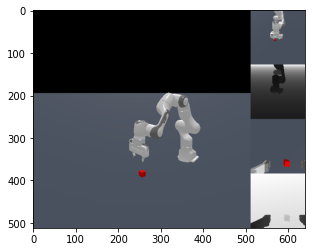

In [ ]:
env_id = "LiftCube-v0"
obs_mode = "rgbd"
control_mode = "pd_ee_delta_pose"
reward_mode = "dense"
# create our environment with our configs and then reset to a clean state
env = gym.make(env_id, obs_mode=obs_mode, reward_mode=reward_mode, control_mode=control_mode)
obs = env.reset()

# take a look at the current state
img = env.render(mode="cameras")
plt.imshow(img)
env.close()

In [ ]:
# the observations
print("The raw observation", obs.keys()) 
print("The data in the observation:")
print("image", obs["image"].keys())
print("agent", obs["agent"].keys())
print("extra", obs["extra"].keys())

The raw observation odict_keys(['agent', 'extra', 'camera_param', 'image'])
The data in the observation:
image odict_keys(['base_camera', 'hand_camera'])
agent odict_keys(['qpos', 'qvel', 'base_pose'])
extra odict_keys(['tcp_pose'])


There are quite a few things, all of which are important for solving the robotics environments! For in-depth details on the exact data stored here, see the wiki: https://github.com/haosulab/ManiSkill2/wiki/Observation-Space

### 2.1 Vectorized Environments on the GPU

For learning and evaluation, vectorized environments enable you to take actions and receive observations in parallel and accelerating everything. As a result, vectorized environments are critical for fast reinforcement learning.

We provide a custom `VecEnv` object and `make_vec_env` function to additionally optimize this vectorization onto the GPU. Note that this is different from the typical `SubProcEnv` used by libraries such as SB3 which do not have a GPU optimization.

For vectorized environments that return visual observations, these observations are kept on the GPU as PyTorch cuda tensors as shown below and now have an extra batch dimension


In [ ]:
from mani_skill2.vector import VecEnv, make as make_vec_env
num_envs = 2 # recommended value for Google Colab. If you have more cores and a more powerful GPU you can increase this
env: VecEnv = make_vec_env(
    env_id,
    num_envs,
    obs_mode=obs_mode,
    reward_mode=reward_mode,
    control_mode=control_mode,
)
env.seed(0)
obs = env.reset()
print("Base Camera RGB:", obs['image']['base_camera']['rgb'].shape)
print("Base Camera RGB device:", obs['image']['base_camera']['rgb'].device)
env.close()

2023-01-28 05:23:49,839 - mani_skill2 - INFO - RenderServer is running at: localhost:41101


Base Camera RGB: torch.Size([2, 128, 128, 3])
Base Camera RGB device: cuda:0


### 2.2 Adapting ManiSkill environments for Stable Baselines with an Observation Wrapper

If you look at the observation space and the returned observation, you will notice that it is a nested dictionary with different values in there, including both image data from cameras and state data about the robot. If you use the GPU optimized VecEnv then some of it is on the GPU (SB3 expects numpy observations)

SB3 won't be able to use this out of the box so we can define a custom observation wrapper to make the ManiSkill environment conform with SB3. Here, we are simply going to take the two RGB images, two depth images from both cameras (base camera and hand camera) and the state data and create a workable observation for SB3.

Feel free to the use the code as is and skip this section. If you want additional customization such as using robot segmentation data, point cloud data etc., you will need to edit the below wrapper appropriately.

In [ ]:
from mani_skill2.vector.vec_env import VecEnvObservationWrapper
from mani_skill2.utils.common import flatten_dict_space_keys, flatten_state_dict

class ManiSkillRGBDWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        assert env.obs_mode == "rgbd"
        self.observation_space = self.init_observation_space(env.observation_space)

    @staticmethod
    def init_observation_space(obs_space: spaces.Dict):
        # States include robot proprioception (agent) and task information (extra)
        # NOTE: SB3 does not support nested observation spaces, so we convert them to flat spaces
        state_spaces = []
        state_spaces.extend(flatten_dict_space_keys(obs_space["agent"]).spaces.values())
        state_spaces.extend(flatten_dict_space_keys(obs_space["extra"]).spaces.values())
        # Concatenate all the state spaces
        state_size = sum([space.shape[0] for space in state_spaces])
        state_space = spaces.Box(-np.inf, np.inf, shape=(state_size,))

        # Concatenate all the image spaces
        image_shapes = []
        for cam_uid in obs_space["image"]:
            cam_space = obs_space["image"][cam_uid]
            image_shapes.append(cam_space["rgb"].shape)
            image_shapes.append(cam_space["depth"].shape)
        image_shapes = np.array(image_shapes)
        assert np.all(image_shapes[0, :2] == image_shapes[:, :2]), image_shapes
        h, w = image_shapes[0, :2]
        c = image_shapes[:, 2].sum(0)
        rgbd_space = spaces.Box(0, np.inf, shape=(h, w, c))

        # Create the new observation space
        return spaces.Dict({"rgbd": rgbd_space, "state": state_space})

    @staticmethod
    def convert_observation(observation):
        # Process images. RGB is normalized to [0, 1].
        images = []
        for cam_uid, cam_obs in observation["image"].items():
            rgb = cam_obs["rgb"] / 255.0
            depth = cam_obs["depth"]

            # NOTE: SB3 does not support GPU tensors, so we transfer them to CPU.
            # For other RL frameworks that natively support GPU tensors, this step is not necessary.
            if isinstance(rgb, th.Tensor):
                rgb = rgb.to(device="cpu", non_blocking=True)
            if isinstance(depth, th.Tensor):
                depth = depth.to(device="cpu", non_blocking=True)

            images.append(rgb)
            images.append(depth)

        # Concatenate all the images
        rgbd = np.concatenate(images, axis=-1)

        # Concatenate all the states
        state = np.hstack(
            [
                flatten_state_dict(observation["agent"]),
                flatten_state_dict(observation["extra"]),
            ]
        )

        return dict(rgbd=rgbd, state=state)

    def observation(self, observation):
        return self.convert_observation(observation)


# We separately define an VecEnv observation wrapper for the ManiSkill VecEnv
# as the gpu optimization makes it incompatible with the SB3 wrapper
class ManiSkillRGBDVecEnvWrapper(VecEnvObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        assert env.obs_mode == "rgbd"
        self.observation_space = ManiSkillRGBDWrapper.init_observation_space(
            env.observation_space
        )

    def observation(self, observation):
        return ManiSkillRGBDWrapper.convert_observation(observation)

We can now wrap the original environment and we'll see the returned observations are now more compact and importantly usable by SB3. Note that the rgbd information is now a numpy array as opposed to a PyTorch tensor on the GPU as we converted with the wrapper for SB3. For faster RL, you can use an RL library that supports observations on the GPU like [RL-Games](https://github.com/Denys88/rl_games) or our own library [ManiSkill2-Learn](https://github.com/haosulab/ManiSkill2-Learn)

In [ ]:
num_envs = 2
env: VecEnv = make_vec_env(
    env_id,
    num_envs,
    obs_mode=obs_mode,
    control_mode=control_mode
)
# use the VecEnvWrapper we created earlier for RGBD data
env = ManiSkillRGBDVecEnvWrapper(env)
env.seed(0)
obs = env.reset()
print(obs.keys())
print("rgbd shape", obs["rgbd"].shape)
print("rgbd type", type(obs["rgbd"]))
print("state shape", obs["state"].shape)
env.close()

2023-01-28 05:23:59,137 - mani_skill2 - INFO - RenderServer is running at: localhost:43609


dict_keys(['rgbd', 'state'])
rgbd shape (2, 128, 128, 8)
rgbd type <class 'numpy.ndarray'>
state shape (2, 32)


### 2.3 Creating a model to process RGBD and State data

SB3 natively doesn't support processing RGB data with depth information, so we will need to create a custom network to process that data. We can make use of the SB3 BaseExtractor class to do this so we can fit our model into any of SB3's algorithms. For more details on feature extractors see the SB3 docs: https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html#custom-feature-extractor

In [ ]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
class CustomExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict):
        super().__init__(observation_space, features_dim=1)

        extractors = {}

        total_concat_size = 0
        feature_size = 256

        for key, subspace in observation_space.spaces.items():
            # We go through all subspaces in the observation space.
            # We know there will only be "rgbd" and "state", so we handle those below
            if key == "rgbd":
                # here we use a NatureCNN architecture to process images, but any architecture is permissble here
                in_channels = subspace.shape[-1]
                cnn = nn.Sequential(
                    nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4, padding=0),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0),
                    nn.ReLU(),
                    nn.Flatten()
                )
                
                # to easily figure out the dimensions after flattening, we pass a test tensor
                test_tensor = th.zeros([subspace.shape[2], subspace.shape[0], subspace.shape[1]])
                with th.no_grad():
                    n_flatten = cnn(test_tensor[None]).shape[1]
                fc = nn.Sequential(nn.Linear(n_flatten, feature_size), nn.ReLU())
                extractors["rgbd"] = nn.Sequential(cnn, fc)
                total_concat_size += feature_size
            elif key == "state":
                # for state data we simply pass it through a single linear layer
                state_size = subspace.shape[0]
                extractors["state"] = nn.Linear(state_size, 64)
                total_concat_size += 64

        self.extractors = nn.ModuleDict(extractors)
        self._features_dim = total_concat_size

    def forward(self, observations) -> th.Tensor:
        encoded_tensor_list = []
        # self.extractors contain nn.Modules that do all the processing.
        for key, extractor in self.extractors.items():
            if key == "rgbd":
                observations[key] = observations[key].permute((0, 3, 1, 2))
            encoded_tensor_list.append(extractor(observations[key]))
        # Return a (B, self._features_dim) PyTorch tensor, where B is batch dimension.
        return th.cat(encoded_tensor_list, dim=1)

We have a custom model / feature extractor ready, an observation wrapper that allows SB3 to work with ManiSkill environments, all that is left now is to setup an RL agent and train, evaluate, and monitor it.

### 2.4 Setting up Training and Evaluation environments

First, we will create vectorized environments to speed up training by using the `make_vec_env` function from earlier. We will also make evaluation environments to record evaluation videos during and after training.

Additionally, note that we also use the `SB3VecEnvWrapper` wrapper which we provide. This is to format the Maniskill `VecEnv` into a SB3 compatible one so SB3 wrappers like `VecMonitor` can also work, too.

Note that currently Maniskill `VecEnv` does not support rendering with `env.render`. So we will need to create a `make_env` function that uses `gym.make` to create environments as well for evaluation purposes and recording videos

In [ ]:
from mani_skill2.vector.wrappers.sb3 import SB3VecEnvWrapper
from mani_skill2.utils.wrappers import RecordEpisode
from mani_skill2.utils.wrappers.sb3 import ContinuousTaskWrapper, SuccessInfoWrapper
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor
from stable_baselines3.common.utils import set_random_seed
from functools import partial

num_envs = 2 # you can increases this if you have more cores to speed up training
env_id = "LiftCube-v0"
obs_mode = "rgbd"
control_mode = "pd_ee_delta_pose"
reward_mode = "dense"

# define a make_env function for Stable Baselines
def make_env(env_id: str, max_episode_steps=None, record_dir: str = None):
    # NOTE: Import envs here so that they are registered with gym in subprocesses
    import mani_skill2.envs

    env = gym.make(env_id, obs_mode=obs_mode, control_mode=control_mode)
    # For training, we regard the task as a continuous task with infinite horizon.
    # you can use the ContinuousTaskWrapper here for that
    if max_episode_steps is not None:
        env = ContinuousTaskWrapper(env, max_episode_steps)
    env = ManiSkillRGBDWrapper(env)
    # For evaluation, we record videos
    if record_dir is not None:
        env = SuccessInfoWrapper(env)
        env = RecordEpisode(env, record_dir, save_trajectory=False, info_on_video=True, render_mode="cameras")
    return env

# create one eval environment. Partial must be used here
env_fn = partial(
    make_env,
    env_id,
    record_dir="logs/videos",
)
eval_env = SubprocVecEnv([env_fn for i in range(1)])
eval_env = VecMonitor(eval_env) # attach this so SB3 can log reward metrics
eval_env.seed(0)
eval_env.reset()

# create num_envs training environments, with max_episode_steps=100
# instead of the default 200 to speed up training
env: VecEnv = make_vec_env(
    env_id,
    num_envs,
    obs_mode=obs_mode,
    reward_mode=reward_mode,
    control_mode=control_mode,
    # specify wrappers for each individual environment e.g here we specify the
    # Continuous task wrapper and pass in the max_episode_steps parameter via the partial tool
    wrappers=[
        partial(ContinuousTaskWrapper, max_episode_steps=100)
    ]
)
env = ManiSkillRGBDVecEnvWrapper(env)
# use the maniskill provided SB3VecEnvWrapper to make the environment compatible with SB3
env = SB3VecEnvWrapper(env)
env = VecMonitor(env)
env.seed(0)
obs = env.reset()

2023-01-28 05:24:10,533 - mani_skill2 - INFO - RenderServer is running at: localhost:54957


To help monitor our training, we can create an evaluation callback function as well as a checkpoint callback function using SB3. The evaluation callback will periodically evaluate the agent without noise and save results to the logs folder. The `eval_env` will also save videos to `logs/videos`. Whenever the evaluation reward has improved, it will save a new best model as well. Finally, the checkpoint callback will periodically save the training progress over time. 

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback

eval_callback = EvalCallback(eval_env, best_model_save_path="./logs/",
                         log_path="./logs/", eval_freq=32000,
                         deterministic=True, render=False)
checkpoint_callback = CheckpointCallback(
    save_freq=32000,
    save_path="./logs/",
    name_prefix="rl_model",
    save_replay_buffer=True,
    save_vecnormalize=True,
)

### 2.5 RL Training with PPO
Finally, we can begin training. We have to first define the policy and training configuration. The configs provided are already tuned and will be able to train out a succesful LiftCube policy. The configs are set to perform a rollout of 3200 steps split across each parallel environment, and update the policy with batch size 400 for 5 epochs. All logs, including tensorboard logs (run `tensorboard --logdir logs` to vie wthem) and evaluation videos are stored in the `logs` folder.

In [ ]:
from stable_baselines3 import PPO

set_random_seed(0) # set SB3's global seed to 0
rollout_steps = 3200

# create our model
policy_kwargs = dict(features_extractor_class=CustomExtractor, net_arch=[256, 128])
model = PPO("MultiInputPolicy", env, policy_kwargs=policy_kwargs, verbose=1,
    n_steps=rollout_steps // num_envs, batch_size=400,
    n_epochs=5,
    tensorboard_log="./logs",
    gamma=0.8,
    target_kl=0.2
)

Using cuda device


Run the next cell to train the model for 250,000+ steps. The final model is then saved to `logs/latest_model`. This can take 15 min to 1 hour (depending on your machine) to finish training. To speed up training you can use a computer with more CPU cores and/or a more powerful GPU.

To keep track of training progress you can go to `logs/videos` and download the evaluation videos saved during training.

We have also provided weights trained through this colab tutorial so if you wish to skip the training time  you can skip the next cell and run the following one

In [ ]:
# Train with PPO
model.learn(160_000, callback=[checkpoint_callback, eval_callback])
model.save("./logs/latest_model")

# optionally load back the model that was saved
model = model.load("./logs/latest_model")

Logging to ./logs/PPO_2
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | 20.305733 |
| time/              |           |
|    fps             | 106       |
|    iterations      | 1         |
|    time_elapsed    | 29        |
|    total_timesteps | 3200      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | 21.810703   |
| time/                   |             |
|    fps                  | 105         |
|    iterations           | 2           |
|    time_elapsed         | 60          |
|    total_timesteps      | 6400        |
| train/                  |             |
|    approx_kl            | 0.008557048 |
|    clip_fraction        | 0.0849      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.93       |
|    explained_variance   | -0.108    

In [ ]:
# Code for simply loading a pretrained policy
import gdown
gdown.download("https://drive.google.com/uc?id=1PjOR6qTVU7XViIqHp06GwA-ItuA0tXlb&export=download", output="./logs/pretrained_model.zip")
model.policy = model.load("logs/pretrained_model").policy

Downloading...
From: https://drive.google.com/uc?id=1PjOR6qTVU7XViIqHp06GwA-ItuA0tXlb&export=download
To: /content/logs/pretrained_model.zip
100%|██████████| 32.9M/32.9M [00:00<00:00, 196MB/s]


### 2.6 Evaluation
Once a model is trained, whether you ran the script above or downloaded the pretrained policy, you can run below to evaluate it and save some videos. You can set `render=True` if you have a GUI to create to live render the evaluation.

If you use default configurations / use the pretrained model, you should get around 60%+ success rate on LiftCube. If you train longer you can get 90%+ success rate.

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
eval_env.close() # close the old eval env
# make a new one that saves to a different directory
env_fn = partial(
    make_env,
    env_id,
    record_dir="logs/eval_videos",
)
eval_env = SubprocVecEnv([env_fn for i in range(1)])
eval_env = VecMonitor(eval_env) # attach this so SB3 can log reward metrics
eval_env.seed(0)
eval_env.reset()

returns, ep_lens = evaluate_policy(model, eval_env, deterministic=True, render=False, return_episode_rewards=True, n_eval_episodes=5)
success = np.array(ep_lens) < 200 # episode length < 200 means we solved the task before time ran out
success_rate = success.mean()
print(f"Success Rate: {success_rate}")
print(f"Episode Lengths: {ep_lens}")

Success Rate: 0.8
Episode Lengths: [16, 200, 13, 68, 54]


In [ ]:
from IPython.display import Video
Video("./logs/eval_videos/2.mp4", embed=True) # Watch one of the replays

## 3 Final Thoughts

This tutorial demonstrates a simple approach to solving ManiSkill2 environments with state-based and visual-based Reinforcement Learning (RL). While LiftCube may appear solved already, other environments are much more complex and solving them scalably is an open problem!

Imitation Learning (IL) is another technique which leverages the demonstration dataset of ManiSkill2 to learn more complex . For a tutorial on Imitation Learning with ManiSkill2, see our [IL Colab Tutorial](https://colab.research.google.com/github/haosulab/ManiSkill2/blob/tutorials/examples/tutorials/3_imitation_learning.ipynb)

While our environments and code enable much faster visual-based RL and IL compared to other robotics environments, there are still a number of approaches that can enhance visual-based policies. Many of these approaches have been consolidated into our own library called [ManiSkill2-Learn](https://github.com/haosulab/ManiSkill2-Learn) which has code to leverage RGBD and PointClouds, transformers, and more.

